# run_car

In [1]:
import datetime
import numpy as np
import random

In [2]:
from cars.world import SimpleCarWorld
from cars.agent import SimpleCarAgent
from cars.physics import SimplePhysics
from cars.track import generate_map

# базовый пример кода
```
if filename:
    agent = SimpleCarAgent.from_file(filename)
    w = SimpleCarWorld(1, m, SimplePhysics, SimpleCarAgent, timedelta=0.2)
    if evaluate:
        print(w.evaluate_agent(agent, steps))
    else:
        w.set_agents([agent])
        w.run(steps)
else:
    w = SimpleCarWorld(1, m, SimplePhysics, SimpleCarAgent, timedelta=0.2)
    w.run(steps)
```

In [3]:
def create_map(seed, agent):
    np.random.seed(seed)
    random.seed(seed)
    m = generate_map(8, 5, 3, 3)
    w = SimpleCarWorld([agent], m, SimplePhysics, None, timedelta=0.2)
    return w

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

class DynamicPlot:
    def __init__(self, xlim=(None, None)):
        self.xlim = xlim
        self.X = []
        self.Y = []
        self.on_launch()

    def on_launch(self):
        self.figure, ax = plt.subplots()
        self.ax = ax
        self.lines, = ax.plot(self.X, self.Y)
        #Autoscale on unknown axis and known lims on the other
        ax.set_autoscaley_on(True)
        ax.set_autoscalex_on(True)
        #ax.set_xlim(*self.xlim)
        #Other stuff
        #ax.grid()

    def clear(self):
        #Update data (with the new _and_ the old points)
        self.X = []
        self.Y = []
        self._update()
        
    def add_point(self, x, y):
        #Update data (with the new _and_ the old points)
        self.X.append(x)
        self.Y.append(y)
        self._update()
    
    def _update(self):
        self.lines.set_xdata(self.X)
        self.lines.set_ydata(self.Y)
        #Need both of these in order to rescale
        self.ax.relim()
        self.ax.autoscale_view()
        #We need to draw *and* flush
        self.figure.canvas.draw()
        self.figure.canvas.flush_events()

# Агент

In [5]:
def agent_callback(agent):
    reward = np.array(agent.reward_clean_history)[-100:].mean()
    print("revard", reward)
    learn_plot.add_point(agent.step, reward)

In [6]:
random.seed(42)
np.random.seed(42)
agent = SimpleCarAgent(name="Ivan", visual_callback=agent_callback)

Пример `agent = SimpleCarAgent.from_file('network_config_agent_0_layers_9_6_1.txt')`

# Параметры

In [7]:
train_params = [
    (0.40, 2000,),
    (0.20, 2000,),
]

map_seeds = [23, 15, 21, 42]

<IPython.core.display.Javascript object>


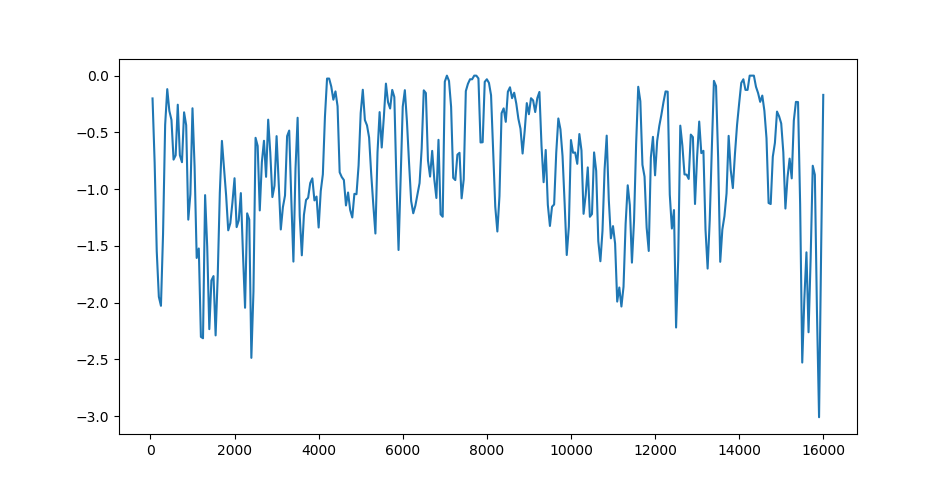

In [8]:
learn_plot = DynamicPlot()

# Учим модель

In [9]:
for rap, steps in train_params:
    agent.RANDOM_ACTION_P = rap

    for map_seed in map_seeds:
        print("train on map = {}".format(map_seed))

        # Меняем карту
        w = create_map(seed=map_seed, agent=agent)

        # Учимся
        w.run(steps=steps, visual=False)

        # чистим историю: не учимся повторно на старой карте, ускоряемся
        agent.clear_history()
        #learn_plot.clear()

train on map = 23
revard -0.200822401036
revard -0.765477643984
revard -1.54700827554
revard -1.94833996465
revard -2.02776133372
revard -1.39500155137
revard -0.433638350229
revard -0.118875845895
revard -0.310875845895
revard -0.390044335811
revard -0.739970564045
revard -0.701926228234
revard -0.256
revard -0.701129396416
revard -0.762580966054
revard -0.323110177525
revard -0.436411463451
revard -1.26879730122
revard -1.04314208971
revard -0.287467878723
revard -0.801751377078
revard -1.60622967962
revard -1.52284435028
revard -2.30110915308
revard -2.31372808547
revard -1.05260293227
revard -1.50630802058
revard -2.23354675054
revard -1.80417975829
revard -1.76585642679
revard -2.28851834062
revard -1.76637762606
revard -1.03242825389
revard -0.574911945313
revard -0.81793624605
revard -1.05600507609
revard -1.36296223472
revard -1.29956277039
revard -1.11700270533
revard -0.903830874307
Saved agent parameters to 'network_config_agent_0_layers_9_6_1.txt'
train on map = 15
revard -

# Оцениваем

In [10]:
print("- time = {}, train_params = {}".format(datetime.datetime.now(), train_params))

for map_seed in map_seeds:
    # Меняем карту
    w = create_map(seed=map_seed, agent=agent)
    
    # оцениваем
    revard = w.evaluate_agent(agent, steps=800, visual=False)
    print("  - evaluate_agent on map = {}, reward = {}".format(map_seed, revard))

- time = 2018-01-25 23:48:09.524151, train_params = [(0.4, 2000), (0.2, 2000)]
  - evaluate_agent on map = 23, reward = -0.9642339247654708
  - evaluate_agent on map = 15, reward = -2.5192296993670387
  - evaluate_agent on map = 21, reward = -2.8168753875083836
  - evaluate_agent on map = 42, reward = -2.9760000000000004


- time = 2018-01-25 23:48:09.524151, train_params = [(0.4, 2000), (0.2, 2000)]
  - evaluate_agent on map = 23, reward = -0.9642339247654708
  - evaluate_agent on map = 15, reward = -2.5192296993670387
  - evaluate_agent on map = 21, reward = -2.8168753875083836
  - evaluate_agent on map = 42, reward = -2.9760000000000004
- time = 2018-01-25 22:30:17.445186, train_params = [(0.4, 1000), (0.2, 1000)]
  - evaluate_agent on map = 23, reward = -1.0748786753725963
  - evaluate_agent on map = 15, reward = -0.7286997971342467
  - evaluate_agent on map = 21, reward = -0.8760332330883187
  - evaluate_agent on map = 42, reward = -0.7286153210942956
- time = 2018-01-24 00:37:51.303347, train_params = [(0.2, 1000)]
  - evaluate_agent on map = 23, reward = -1.7741872447429086
  - evaluate_agent on map = 15, reward = -1.5800781959803243
  - evaluate_agent on map = 21, reward = -0.8135290975234429
  - evaluate_agent on map = 42, reward = -1.7857630295989895


# Смотрим вживую и продолжаем учиться

In [ ]:
agent.RANDOM_ACTION_P = 0.00

for map_seed in map_seeds[:1]:
    print("train on map = {}".format(map_seed))

    # Меняем карту
    w = create_map(seed=map_seed, agent=agent)

    # Учимся
    w.run(steps=None, visual=True)

In [ ]:
# чистим историю: не учимся повторно на старой карте, ускоряемся
agent.clear_history()

# Немного покатаемся для отладки

In [ ]:
for map_seed in map_seeds:
    # Меняем карту
    w = create_map(seed=map_seed, agent=agent)
    
    # оцениваем
    revard = w.evaluate_agent(agent, steps=200, visual=True)
    print("evaluate_agent on map = {}, reward = {}".format(map_seed, revard))

# Debug

In [ ]:
agent = w.agents[0]

In [ ]:
np.concatenate([
    np.array(agent.sensor_data_history)[:,:1],
    np.array(agent.chosen_actions_history),
    np.array(agent.reward_history).reshape(-1,1)
], axis=1)

In [ ]:
agent.RANDOM_ACTION_P